....

Saving villes.csv to villes (7).csv
Les Fichier chargé est : villes (7).csv
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Affichage du fichier chargé csv
       ville  latitude  longitude       pays  population
0      Tokyo   35.6897   139.6922      Japan  37732000.0
1    Jakarta   -6.1750   106.8275  Indonesia  33756000.0
2      Delhi   28.6100    77.2300      India  32226000.0
3  Guangzhou   23.1300   113.2600      China  26940000.0
4     Mumbai   19.0761    72.8775      India  24973000.0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Les données sont déjà structurées.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

 Le Nettoyage des données en cours
       ville  latitude  longitude   

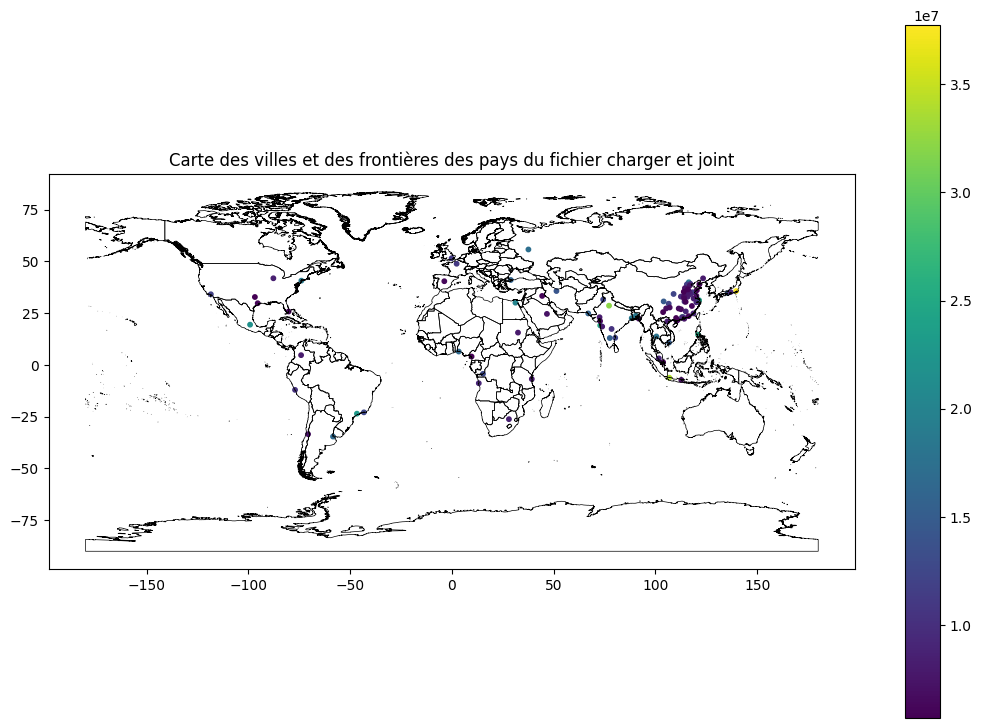

.
----------------------------------------------------------------------
Ran 5 tests in 1.505s

OK


In [ ]:

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import matplotlib.pyplot as plt
import unittest
from google.colab import files

# Téléchargement manuel des fichiers
uploaded = files.upload()


# Vérification des fichiers uploadés
for fichier in uploaded.keys():
    print(f"Les Fichier chargé est : {fichier}")

# Déclaration des fichiers
VILLES= 'villes.csv'
SHAPE = 'pays.shp'

# Chargement du fichier csv
def charger_fichier(fichier):
    if not os.path.exists(fichier):
        raise FileNotFoundError(f"Le fichier {fichier} est introuvable.")
    villes_df = pd.read_csv(fichier, encoding='latin-1')
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("\nAffichage du fichier chargé csv")
    print(villes_df.head())
    return villes_df

# Chargement du shapefile pays.shp
def charger_shapefile(fichier_shp):
    if not os.path.exists(fichier_shp):
        raise FileNotFoundError(f"Le fichier {fichier_shp} est introuvable.")
    pay = gpd.read_file(fichier_shp)
    if pay.crs is None:
        print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print("\nCRS  si il ya manquant dans le shapefile, attribution de EPSG:4326.")
        pay.set_crs("EPSG:4326", inplace=True)
    return pay

# Repartir les donnes des colonnes si les donnees sont stocker dans une seul cellule qui creent des donnees manquants
def repartir(villes_df):
    if len(villes_df.columns) >= 5:
        print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print("\nLes données sont déjà structurées.")
        return villes_df
    villes_corrected = villes_df['ville'].str.split(',', expand=True)
    villes_corrected.columns = ['ville', 'pays', 'population', 'latitude', 'longitude'][:villes_corrected.shape[1]]
    return villes_corrected.dropna()

# Nettoyage des donees de du fichier charger
def nettoyage(villes_df):
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("\n Le Nettoyage des données en cours")
    villes_df = villes_df.dropna(subset=['ville', 'population', 'latitude', 'longitude'])
    villes_df = villes_df[
        (villes_df['population'] > 0) &
        (villes_df['latitude'].between(-90, 90)) &
        (villes_df['longitude'].between(-180, 180))
    ]
    print(villes_df.head())
    return villes_df

# Permet d'obtenir les statistique
def statistiques_population(villes_df):
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("\n Les Statistiques descriptives sur la population :")
    stats = villes_df['population'].describe()
    print(stats)
    return stats

#La Conversion en GeoDataFrame
def conversion_en_Geodataframe(villes_df):
    villes_df['geo'] = villes_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    gdf = gpd.GeoDataFrame(villes_df, geometry='geo', crs="EPSG:4326")
    return gdf

# Jointure spatiale des deux fichier
def jointure(gdf, pay):
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("\nJointure spatiale en cours desdeux fichiers charger")
    gdf_joined = gpd.sjoin(gdf, pay, how="inner", predicate="within")
    print(gdf_joined.head())
    return gdf_joined

# La visualisation des donnes
def visualisation_carte(gdf, pay):
    fig, ax = plt.subplots(figsize=(13, 9))
    pay.boundary.plot(ax=ax, color='black', linewidth=0.5)
    gdf.plot(ax=ax, column='population', cmap='viridis', legend=True, markersize=10)
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    ax.set_title("Carte des villes et des frontières des pays du fichier charger et joint")
    plt.show()

# Tests unitaires
class TestGeospatialAnalysis(unittest.TestCase):
    @classmethod
    def setUpClass(cl):
        cl.villes = charger_fichier(VILLES)
        cl.villes = repartir(cl.villes)
        cl.villes = nettoyage(cl.villes)
        cl.pay = charger_shapefile(SHAPE)

    def test_nettoyage(self):
        self.assertGreater(len(self.villes), 0)
        self.assertTrue((self.villes['population'] > 0).all())

    def test_statistiques(self):
        stats = statistiques_population(self.villes)
        self.assertGreater(stats['mean'], 0)
        self.assertGreater(stats['max'], stats['min'])

    def test_conversion_geodataframe(self):
        gdf = conversion_en_Geodataframe(self.villes)
        self.assertIsInstance(gdf, gpd.GeoDataFrame)
        self.assertTrue(all(gdf.geometry.apply(lambda x: isinstance(x, Point))))

    def test_jointure(self):
        gdf = conversion_en_Geodataframe(self.villes)
        gdf_joined = jointure(gdf, self.pay)
        self.assertGreater(len(gdf_joined), 0)
        self.assertIn('index_right', gdf_joined.columns)

    def test_visualisation(self):
        try:
            gdf = conversion_en_Geodataframe(self.villes)
            visualisation_carte(gdf, self.pay)
        except Exception as e:
            self.fail(f"La visualisation a echouee : {e}")

if __name__ == "__main__":
    unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestGeospatialAnalysis))
